# Tutorial for implementing custom gradients in JAX

- Goal of this notebook is to better understand how to leverage acceleration libraries to implement custom derivatives.
- Although, most of the libraries like JAX, PyTorch, TensorFlow etc. can easily implement automatic differentiation, there is always a need to implement activation functions that may not be differentiable:
    - Spiking neural networks typically use LIF neurons
    - It is efficient to use simplified backward pass or truncated gradients.
    - We are now working with ternary neurons, which also have discontinuous activation.

- For these type of models, the backward pass in backpropagation or a similar algorithm has to have custom defined gradients.
- As a starting point, this notebook will go through <a href = "https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html">"Custom Derivative Rules" </a> tutorial on JAX documentation page.

In [23]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

## Implementing clipping gradient
- This is a simple function

In [14]:
## implementing a simple clipping gradient

@jax.custom_vjp
def clip_grads(x, lo, hi):
    return x # implement an identity function

def clip_grads_fwd(x, lo, hi):
    return x, (lo, hi) # save bounds as residuals

def clip_grads_bwd(residuals, grads):
    lo, hi = residuals # extract the residuals
    return (jnp.clip(grads, lo, hi), None, None) # return clipped gradients. None indicates no cotangents w.r.t la and hi

clip_grads.defvjp(clip_grads_fwd, clip_grads_bwd)

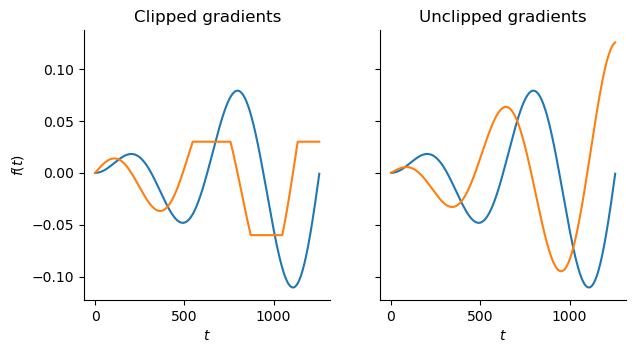

In [22]:
t = jnp.arange(0., 4*jnp.pi, 0.01)

def clip_fn(x):
    x = clip_grads(x, -0.06, 0.03)
    return jnp.sin(x) * 0.01 * x


fig, ax = plt.subplots(1, 2, figsize = (7, 3.5), sharey = True)
ax[0].plot(clip_fn(t))
ax[0].plot(jax.vmap(jax.grad(clip_fn))(t))
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$f(t)$")
ax[0].set_title('Clipped gradients')
ax[1].plot(jnp.sin(t) * 0.01 * t)
ax[1].plot(jax.vmap(jax.grad(jnp.sin))(t) * 0.01 * t)
ax[1].set_title('Unclipped gradients')
ax[1].set_xlabel(r"$t$")

sns.despine()

## Implementing a thresholding function
- In the forward pass implement the Heaviside function.
- In the backward pass implement the sigmoid

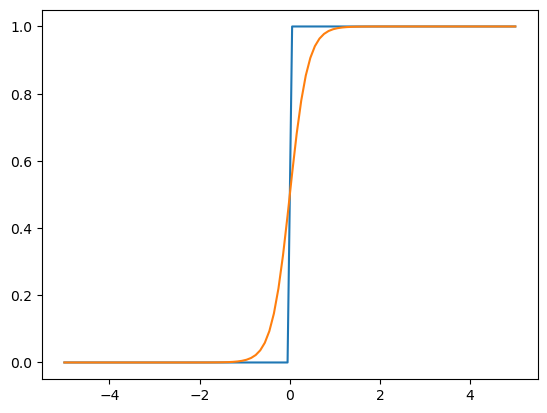

In [48]:
## testing out the functions
def heaviside_fn(x):
    return jnp.where(x > 0.0, 1.0, 0.0)

def sigmoid(x):
    return 1/(1 + jnp.exp(-5*x))

t = jnp.linspace(-5, 5, 100)
plt.plot(t, heaviside_fn(t))
plt.plot(t, sigmoid(t))

In [49]:
@jax.custom_vjp
def custom_step(x):
    return heaviside_fn(x)

def custom_step_fwd(x):
    return custom_step(x), (sigmoid(x),)

def custom_step_bwd(res, grads):
    sig, = res
    return (sig*(1 - sig)*grads, )

custom_step.defvjp(custom_step_fwd, custom_step_bwd)

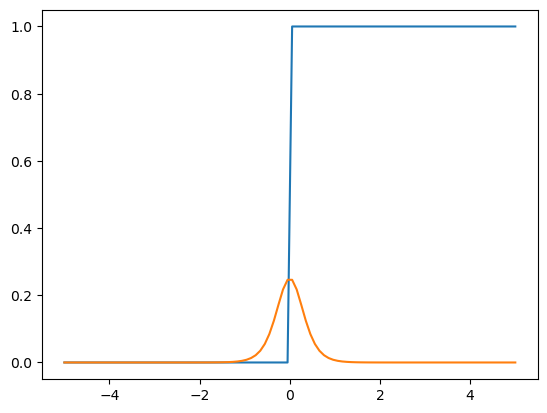

In [50]:
t = jnp.linspace(-5, 5, 100)
plt.plot(t, custom_step(t))
gg = jax.vmap(jax.grad(custom_step))(t)
plt.plot(t, gg)

In [66]:
## discretize the gradients
@jax.custom_vjp
def custom_step2(x):
    return heaviside_fn(x)

def custom_step2_fwd(x):
    return custom_step(x), (sigmoid(x),)

def custom_step2_bwd(res, grads):
    sig, = res
    g_sig = sig*(1 - sig)*grads
    out = jnp.where(g_sig < 0.1, -1.0, jnp.where(g_sig > 0.2, 1.0, 0.0))
    return (out, )

custom_step2.defvjp(custom_step2_fwd, custom_step2_bwd)

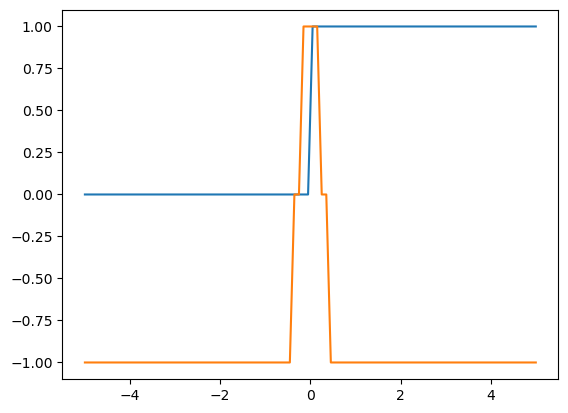

In [67]:
t = jnp.linspace(-5, 5, 100)
plt.plot(t, custom_step2(t))
gg = jax.vmap(jax.grad(custom_step2))(t)
plt.plot(t, gg)

## Implementing the ternary states
- In the forward pass, use ternary activation function.
- In the backward pass, use the derivative of the expected state

In [ ]:
def ternary_activation(x, thresholds):
    t1, t2 = thresholds
    
